In [19]:
pip install resampy seaborn tensorflow librosa np_utils keras pydot graphviz


Note: you may need to restart the kernel to use updated packages.


In [20]:
import os

import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import resampy


from IPython.display import Audio

import librosa
import librosa.display

import keras
import keras.utils
import keras.layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [21]:
audio_data = 'Respiratory_Sound_Database/audio_and_txt_files/'


In [22]:
patient_data=pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [23]:
diagnosis_df = pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,patient_id,diagnosis_name
1,101,URTI
2,102,Healthy
3,103,Asthma


In [24]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
diagnosis_name     1
Asthma             1
Name: count, dtype: int64

disease
COPD              50.393701
Healthy           20.472441
URTI              11.023622
Bronchiectasis     5.511811
Pneumonia          4.724409
Bronchiolitis      4.724409
LRTI               1.574803
diagnosis_name     0.787402
Asthma             0.787402
Name: proportion, dtype: float64


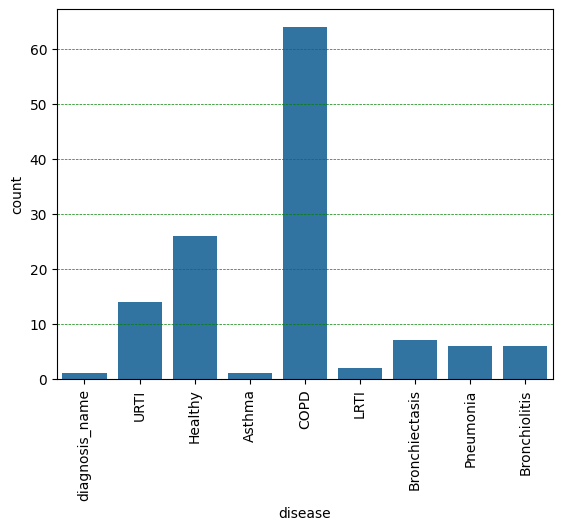

In [25]:
sns.countplot(x='disease', data=diagnosis_df)
plt.xticks(rotation=90)
plt.grid(axis='y', color='green', linestyle='--', linewidth=0.5)
plt.show()


In [26]:
path='Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [27]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretches(data, rate):
    data = librosa.effects.time_stretch(data, rate=rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [28]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretches(y, rate=1.2)
    y_stretch_2 = stretches(y, rate=0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr, color='blue')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr, color='blue')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr, color='blue')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr, color='blue')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr, color='blue')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr, color='blue')
    plt.title('pitch shift')

    plt.tight_layout()

In [29]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretches(y, 1.2)
    y_stretch_2 = stretches(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')
    
    

    plt.tight_layout()

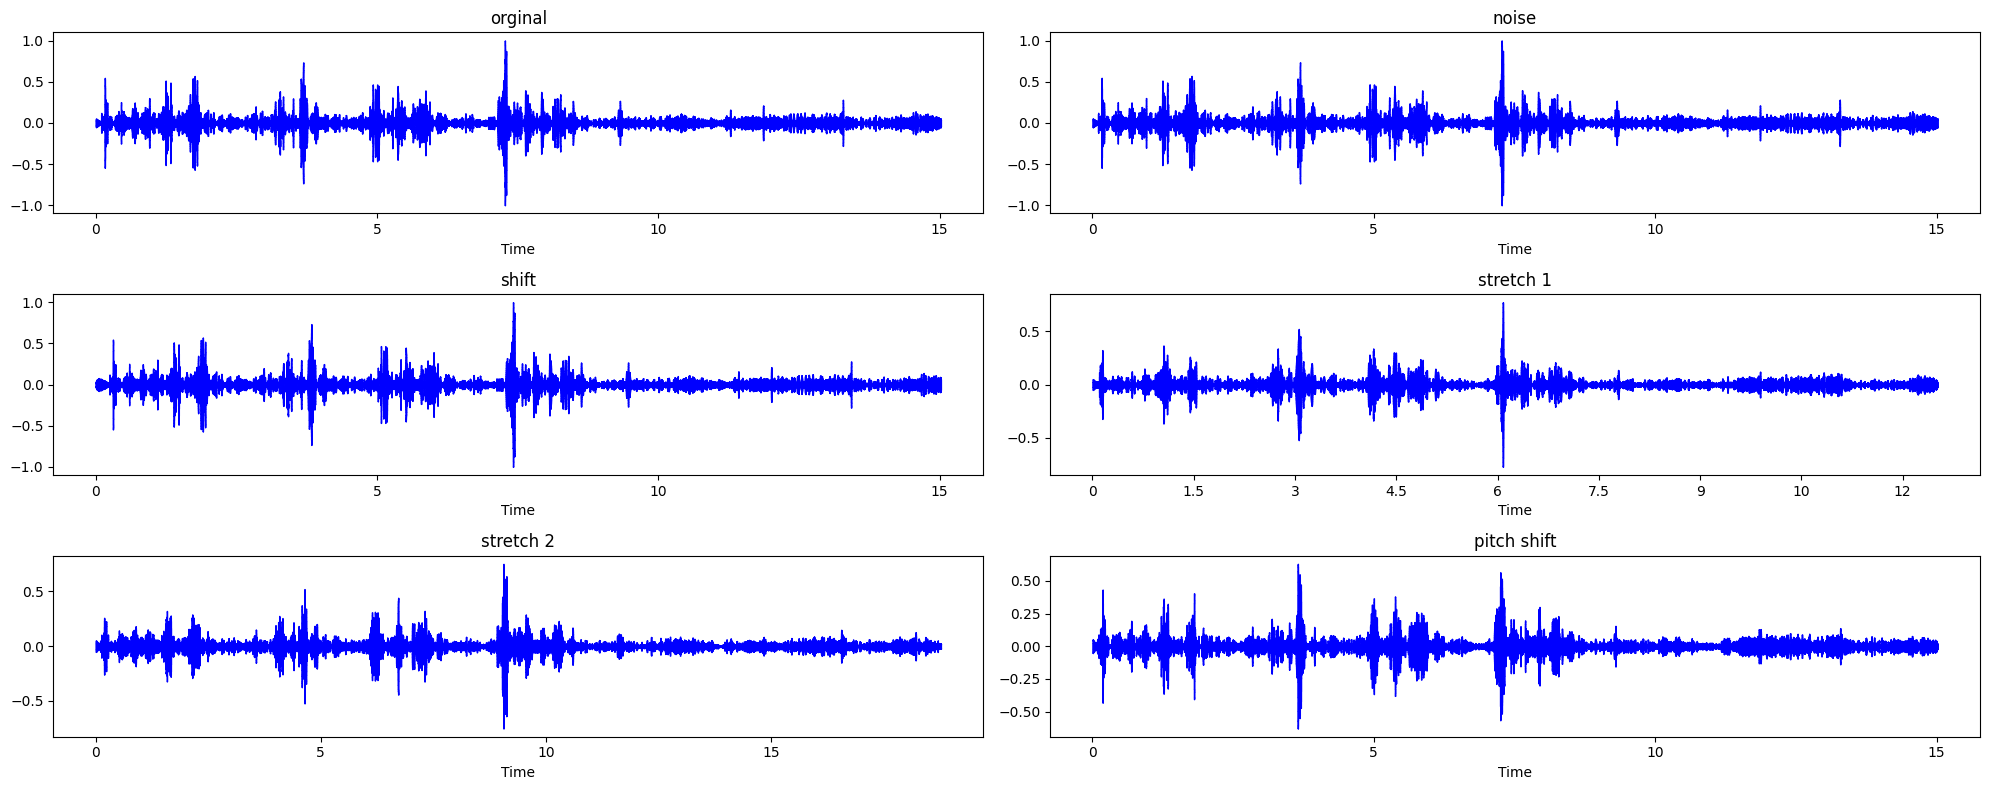

In [30]:
show_audio('Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

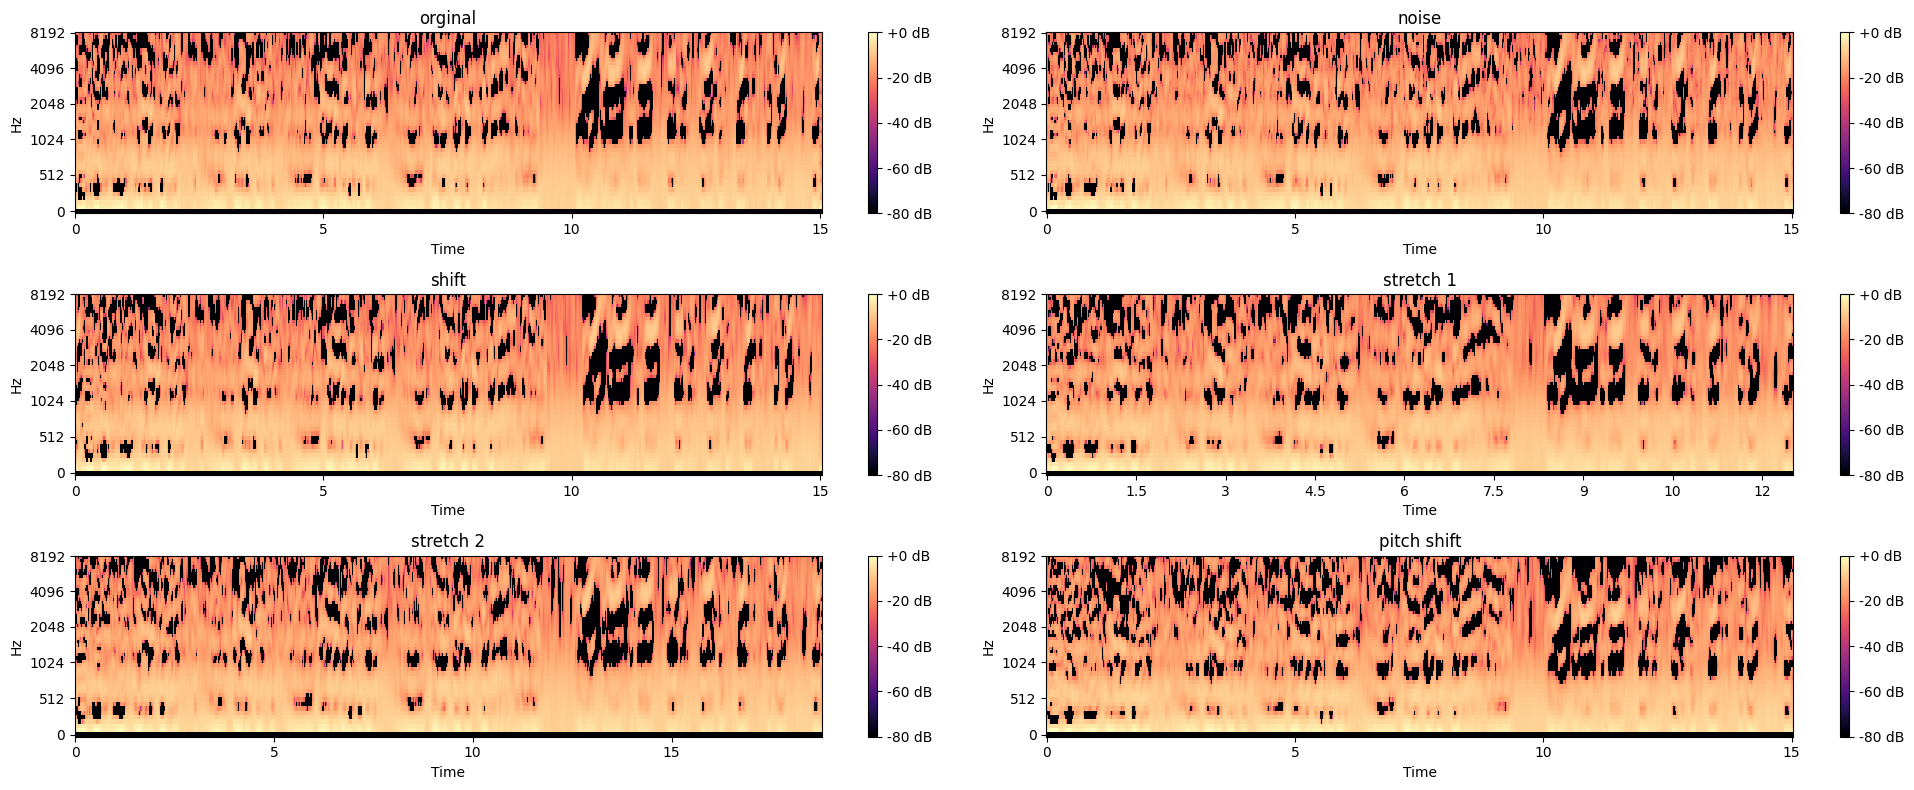

In [31]:
show_audio_features('Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

In [34]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model. 
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables. 
        
        Args: dir_: Input directory to the Sound input file.
        
        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]
    
    COPD=[]
    copd_count=0
    
    data = diagnosis_df
    features = 52
    
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':
            # p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            p = list(data.loc[data['patient_id'] == soundDir[:3], 'disease'])[0]
            # print(list(data.loc[data['patient_id'] == soundDir[:3], 'disease'])[0])
            # print(soundDir[:3])
            # # print(soundDir[:3])
            
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==soundDir[:3]]['disease'])[0])
                    
                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==soundDir[:3]]['disease'])[0])
                
            if (p!='COPD'):
                if (p == 'Bronchiolitis'):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                elif p == 'Bronchiectasis':
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiectasis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiectasis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiectasis')
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiectasis')
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiectasis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiectasis')
                    
                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==soundDir[:3]]['disease'])[0])
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)
                    
                    data_stretch = stretches(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    data_stretch_2 = stretches(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    
                
    X_data = np.array(X_)
    y_data = np.array(y_)

    
    return X_data, y_data 

In [35]:
x_mfccs, y = mfccs_feature_exteraction(audio_data)

In [36]:
def augmented_labels_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

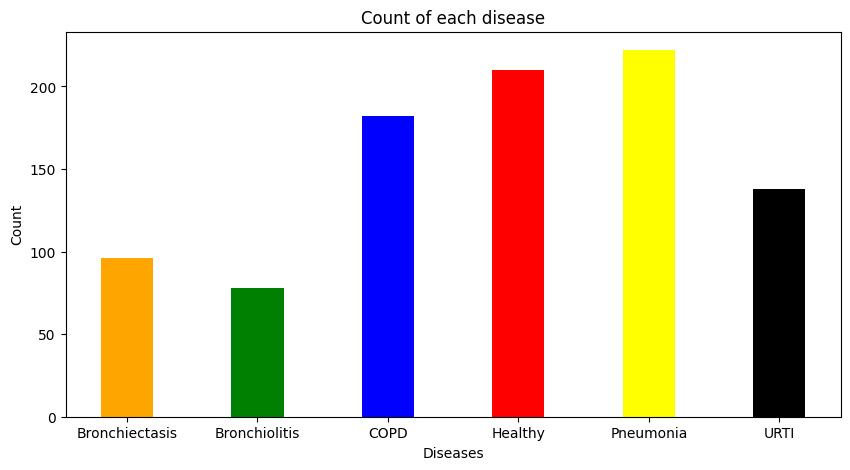

{'Bronchiectasis': 96, 'Bronchiolitis': 78, 'COPD': 182, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [37]:
augmented_labels_count(y)

In [38]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiectasis',np.array([0,0,1,0,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,0,1,0,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,0,1,0]).reshape(1,6) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,0,1]).reshape(1,6) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [39]:
mfccs_features = np.array(x_mfccs)
labels = np.array(Y_data)

mfccs_features.shape , labels.shape

((926, 52), (926, 6))

In [40]:
mfcc_train, mfcc_val, labels_train, labels_val  = train_test_split(mfccs_features, labels, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, labels_train, labels_test = train_test_split(mfcc_train, labels_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (labels_train.shape, labels_val.shape, labels_test.shape)

(705, 52) (163, 52) (58, 52)
(705, 6) (163, 6) (58, 6)


In [41]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [43]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(labels_train,axis=1)
y_val_gru = np.expand_dims(labels_val,axis=1)
y_test_gru = np.expand_dims(labels_test,axis=1)

In [44]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=6, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(6, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 52)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 256)    │     80,128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 256)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 256)    │      1,024 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 512)    │    786,944 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 512)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 512)    │      2,048 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 1, 32)     │     52,416 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 1, 64)     │    110,976 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ (None, 1, 128)    │     74,496 │ gru_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 1, 128)    │     62,208 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 1, 128)    │     74,496 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 128)    │          0 │ gru_13[0][0],     │
│                     │                   │            │ gru_11[0][0],     │
│                     │                   │            │ gru_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 1, 128)    │     99,072 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 1, 64)     │     37,248 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ (None, 1, 32)     │     15,552 │ gru_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 1, 32)     │      9,408 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 32)     │          0 │ gru_17[0][0],     │
│                     │                   │            │ gru_19[0][0],     │
│                     │                   │            │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 32)     │      1,056 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,543,238 (5.89 MB)

 Trainable params: 1,541,702 (5.88 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# tf.keras.utils.plot_model(gru_model, to_file='gru_model.png', show_shapes=True)

In [45]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

In [46]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=200, validation_data=(x_val_gru, y_val_gru))

Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 28s 49ms/step - accuracy: 0.3336 - loss: 1.6810 - val_accuracy: 0.4601 - val_loss: 1.6863
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4819 - loss: 1.3644 - val_accuracy: 0.5276 - val_loss: 1.4873
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5565 - loss: 1.2012 - val_accuracy: 0.5767 - val_loss: 1.2554
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5890 - loss: 1.0818 - val_accuracy: 0.5951 - val_loss: 1.0884
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6103 - loss: 1.0496 - val_accuracy: 0.6319 - val_loss: 1.0247
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6239 - loss: 0.9201 - val_accuracy: 0.6564 - val_loss: 0.9502
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6080 - loss: 0.9873 - val_accuracy: 0.6196 - val_loss: 1.0138
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6748 - loss: 0.8589 - val_accuracy: 0

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9241 - loss: 0.2053


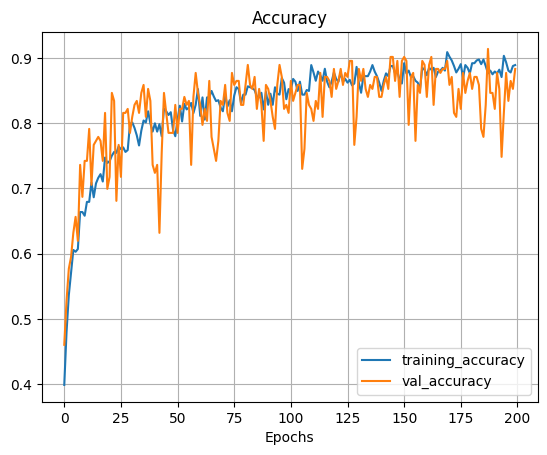

In [47]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)

In [ ]:
# classes = ["COPD" ,"Bronchiolitis ", "Bronchiectasis", "Pneumoina", "URTI", "Healthy"]

# preds = gru_model.predict(x_test_gru)
# classpreds = [np.argmax(t) for t in preds ]
# y_testclass = [np.argmax(t) for t in y_test_gru]
# cm = confusion_matrix(y_testclass, classpreds)

# plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

# plt.title('')
# plt.xlabel('Prediction')
# plt.ylabel('Truth')
# plt.show(ax)

In [ ]:
# print(classification_report(y_testclass, classpreds, target_names=classes))

In [48]:
test_loss, test_acc = gru_model.evaluate(x_test_gru, y_test_gru)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7902 - loss: 0.8091 
Test Accuracy: 0.8103448152542114
Test Loss: 0.7400824427604675


In [49]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Assuming predictions are from a model and x_test_gru is your input for testing
predictions = gru_model.predict(x_test_gru)

# Convert predicted probabilities or outputs to class labels if necessary
if predictions.ndim > 1 and predictions.shape[2] > 1:
    predicted_classes = np.argmax(predictions, axis=2).flatten()
else:
    predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ensure targets are in the correct format
if y_test_gru.ndim > 1 and y_test_gru.shape[2] > 1:
    y_test_gru = np.argmax(y_test_gru, axis=2).flatten()
else:
    y_test_gru = y_test_gru.flatten()

# Convert y_test_gru to integers if it's not already
y_test_gru = y_test_gru.astype(int)

# Calculate precision and recall
precision = precision_score(y_test_gru, predicted_classes, average='macro')
recall = recall_score(y_test_gru, predicted_classes, average='macro')

print(f"Precision: {precision}, Recall: {recall}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Precision: 0.8472222222222222, Recall: 0.8092592592592592


In [52]:
gru_model.save('respiratory_diagnosis_assistant/gru_model.keras')

In [51]:
gru_model.save_weights('gru_model2.weights.h5')

## SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your labels are one-hot encoded
labels = np.array(labels)  # This should be the array with shape (926, 6)

# Convert one-hot encoded labels to single integer labels
labels_single = np.argmax(labels, axis=1)  # This finds the index of the max value in each row

# Now your labels are in the correct shape for typical classifiers
mfccs_features = np.array(x_mfccs)

# Splitting the dataset
mfcc_train, mfcc_test, labels_train, labels_test = train_test_split(mfccs_features, labels_single, test_size=0.075, random_state=10)

# You can now proceed with any classifier that expects a single label per sample

sgd_model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

sgd_model.fit(mfcc_train, labels_train)

result = sgd_model.predict(mfcc_test)

sgd_accuracy = accuracy_score(result, labels_test)
precision = precision_score(result, labels_test, average='macro')  # Change average as needed
recall = recall_score(labels_test, result, average='macro')         # Change average as needed
f1 = f1_score(labels_test, result, average='macro')                 # Change average as needed

print("Accuracy:", sgd_accuracy)
print("precision", precision)
print("recall", recall)

 ## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your labels are one-hot encoded
labels = np.array(labels)  # This should be the array with shape (926, 6)

# Convert one-hot encoded labels to single integer labels
labels_single = np.argmax(labels, axis=1)  # This finds the index of the max value in each row

# Now your labels are in the correct shape for typical classifiers
mfccs_features = np.array(x_mfccs)

# Splitting the dataset
mfcc_train2, mfcc_test2, labels_train2, labels_test2 = train_test_split(mfccs_features, labels_single, test_size=0.075, random_state=10)

# You can now proceed with any classifier that expects a single label per sample

logistic_model = LogisticRegression()

logistic_model.fit(mfcc_train2, labels_train2)

result_logistic_model = logistic_model.predict(mfcc_test2)

accuracy = accuracy_score(result_logistic_model, labels_test2)
precision = precision_score(result_logistic_model, labels_test2, average='macro') 
recall = recall_score(labels_test, result, average='macro')    

print("Accuracy:", accuracy)
print("precision", precision)
print("recall", recall)


## Ridge Classifier


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your labels are one-hot encoded
labels = np.array(labels)  # This should be the array with shape (926, 6)

# Convert one-hot encoded labels to single integer labels
labels_single = np.argmax(labels, axis=1)  # This finds the index of the max value in each row

# Now your labels are in the correct shape for typical classifiers
mfccs_features = np.array(x_mfccs)

# Splitting the dataset
mfcc_train3, mfcc_test3, labels_train3, labels_test3 = train_test_split(mfccs_features, labels_single, test_size=0.075, random_state=10)

# You can now proceed with any classifier that expects a single label per sample

Ridge_model = RidgeClassifier()

Ridge_model.fit(mfcc_train3, labels_train3)

result_Ridge_model = Ridge_model.predict(mfcc_test3)

accuracy = accuracy_score(result_Ridge_model, labels_test3)
precision = precision_score(result_Ridge_model, labels_test3, average='macro') 
recall = recall_score(labels_test, result, average='macro')    

print("Accuracy:", accuracy)
print("precision", precision)
print("recall", recall)

